## Phase III
#### Steven Yu, Jennifer Nguyen, Jason Lo

The original question we posed was "How have nutritional values in foods changed over time?" In phase 3, we created two models that relate time created to nutrient amounts of cereals in the dataset. 

### Model 1: Time Created vs. Sugar

This first model aims to predict the amount of sugars in a cereal based on the time it was added to the database using simple linear regression. 

Intercept: 15.5322
Slope (per ordinal day): 0.000250
RMSE: 13.2266
R^2: 0.0004


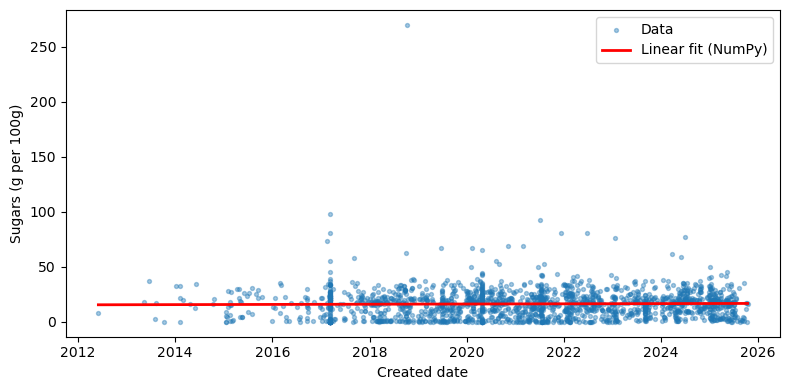

In [16]:
# NumPy-only linear regression: sugars_100g ~ created_t (date)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data, we uploaded food_data.csv to the repo at https://github.com/Lamsheeper/ds3000-final/tree/main and also uploaded with the GradeScope submission
csv_path = "food_data.csv"
df = pd.read_csv(csv_path)

# Parse created_t and clean
df['created_t'] = pd.to_datetime(df['created_t'], errors='coerce')
df = df.dropna(subset=['created_t', 'sugars_100g']).copy()

# Feature: convert date to integer days
t0 = df['created_t'].min()
time_num = (df['created_t'] - t0).dt.days.astype(float)
y = df['sugars_100g'].to_numpy(dtype=float)

# Design matrix with intercept
X = np.column_stack([np.ones_like(time_num), time_num])

# Solve least squares using NumPy
beta, *_ = np.linalg.lstsq(X, y, rcond=None)
intercept, slope = beta

# Predictions and metrics on full data
y_pred = X @ beta
rmse = np.sqrt(np.mean((y - y_pred)**2))
r2 = 1.0 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)

print(f"Intercept: {intercept:.4f}")
print(f"Slope (per ordinal day): {slope:.6f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(df['created_t'], y, s=8, alpha=0.4, label='Data')
order = np.argsort(time_num)
ax.plot(df['created_t'].to_numpy()[order], y_pred[order], color='red', linewidth=2, label='Linear fit (NumPy)')
ax.set_xlabel('Created date')
ax.set_ylabel('Sugars (g per 100g)')
ax.legend()
plt.tight_layout()
plt.show()

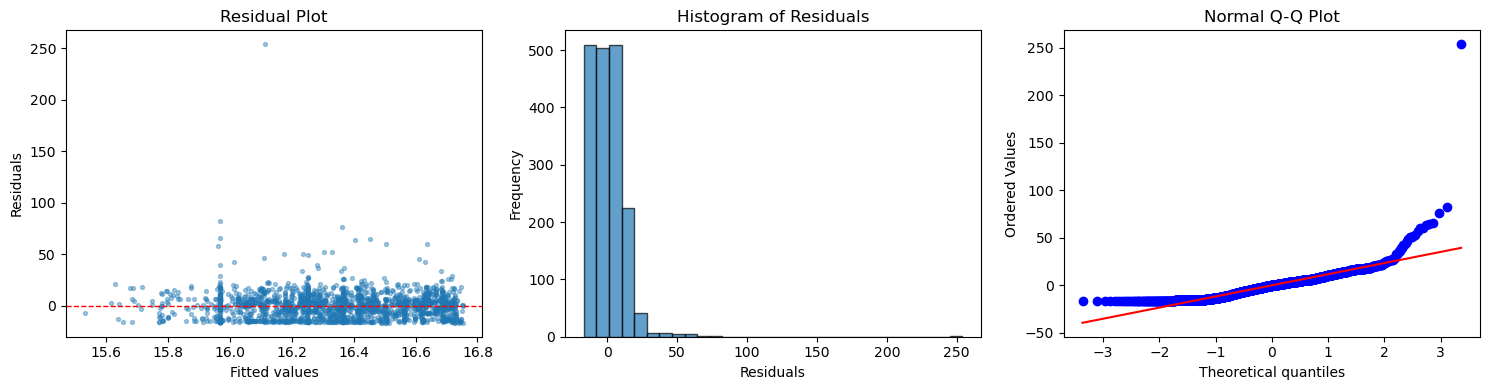

In [17]:
# Diagnostic plots for Model 1
from scipy import stats
residuals = y - y_pred

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residual plot
axes[0].scatter(y_pred, residuals, s=8, alpha=0.4)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')

# Histogram of residuals
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Residuals')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Normal Q-Q Plot')

plt.tight_layout()
plt.show()


### Model 2: Sugar, Fat, & Salt vs. Time Created

This second model uses multiple linear regression to predict the time a cereal was added using the sugar, fat, and salt content of the cereal. 

Intercept (days since 2012-06-02): 3200.6184
Beta sugars_100g (standardized): 14.145854 days per std dev
Beta salt_100g (standardized):   24.220742 days per std dev
Beta fat_100g (standardized):    111.402344 days per std dev
RMSE (days): 993.4304
R^2: 0.0135
n = 1714 rows


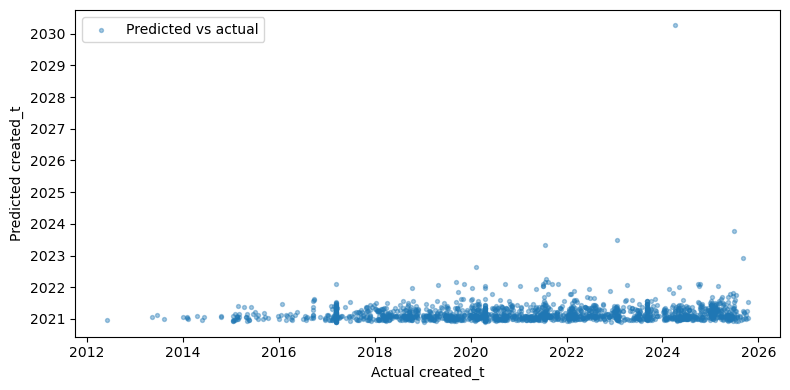

In [18]:
# NumPy multiple regression: created_t (days) ~ sugars_100g + salt_100g + fat_100g
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure required columns exist and drop missing
features = ['sugars_100g', 'salt_100g', 'fat_100g']
needed_cols = features + ['created_t']
sub = df[needed_cols].dropna().copy()

# Convert created_t to numeric days since first date in this subset
t0_multi = sub['created_t'].min()
y_days = (sub['created_t'] - t0_multi).dt.days.astype(float)

# Standardize features (mean=0, std=1)
X_raw = sub[features].to_numpy(dtype=float)
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
X_standardized = (X_raw - X_mean) / X_std

# Design matrix with intercept and standardized features
X_multi = np.column_stack([np.ones(len(sub)), X_standardized])

# Least squares solution
beta_multi, *_ = np.linalg.lstsq(X_multi, y_days.to_numpy(), rcond=None)
intercept_d, b_sugars, b_salt, b_fat = beta_multi

# Predictions and metrics
y_pred_days = X_multi @ beta_multi
rmse_days = np.sqrt(np.mean((y_days - y_pred_days) ** 2))
r2_multi = 1.0 - np.sum((y_days - y_pred_days) ** 2) / np.sum((y_days - y_days.mean()) ** 2)

print(f"Intercept (days since {t0_multi.date()}): {intercept_d:.4f}")
print(f"Beta sugars_100g (standardized): {b_sugars:.6f} days per std dev")
print(f"Beta salt_100g (standardized):   {b_salt:.6f} days per std dev")
print(f"Beta fat_100g (standardized):    {b_fat:.6f} days per std dev")
print(f"RMSE (days): {rmse_days:.4f}")
print(f"R^2: {r2_multi:.4f}")
print(f"n = {len(sub)} rows")

# Optional diagnostic plot: actual vs predicted creation date
pred_dates = t0_multi + pd.to_timedelta(y_pred_days, unit='D')

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(sub['created_t'], pred_dates, s=8, alpha=0.4, label='Predicted vs actual')
ax.set_xlabel('Actual created_t')
ax.set_ylabel('Predicted created_t')
ax.legend()
plt.tight_layout()
plt.show()


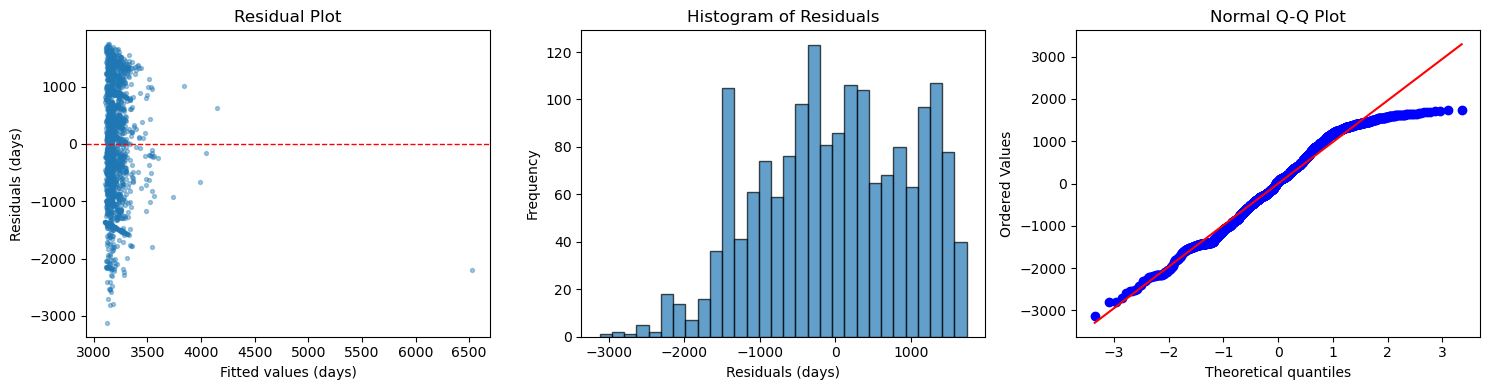

In [19]:
# Diagnostic plots for Model 2
residuals_multi = y_days - y_pred_days

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Residual plot
axes[0].scatter(y_pred_days, residuals_multi, s=8, alpha=0.4)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Fitted values (days)')
axes[0].set_ylabel('Residuals (days)')
axes[0].set_title('Residual Plot')

# Histogram of residuals
axes[1].hist(residuals_multi, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Residuals')

# Q-Q plot
stats.probplot(residuals_multi, dist="norm", plot=axes[2])
axes[2].set_title('Normal Q-Q Plot')

plt.tight_layout()
plt.show()


## Analysis

### Model 1
This model has a very low R^2 value of 0.0004 and a slope that's near 0, suggesting that there is no linear trend between the time a cereal was created in the database and its sugar content. 

The residuals show non-normality, violating the normality assumption. There is a clear right skew from the histogram and the Q-Q plot, and some extreme outliers on the right tail. This suggests that the model could potentially be improved by inducing a transformation on one of the variables, such as taking the log of the sugar content. 

### Model 2
This model also has a very low R^2 value of 0.0135, suggesting that there is no linear trend between sugar/fat/salt content of a cereal and the time it was created in the database. 

The residuals clearly violate homoscedasticity, with the residual plot showing a funnel pattern with variance increasing with fitted values. Normality seems to be satisfied, with the histogram looking normally distributed and the Q-Q plot only having a slight deviation at the right side. 

Again, with the low R^2 value and severe violations, a linear model is not the right model to capture the relationship between time and the provided nutrients, if there is any at all. 

## Conclusion